# Ray Tracing with Taichi

In [ ]:
!pip install taichi

In [ ]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initialize Taichi
ti.init(arch=ti.gpu)

# Image dimensions
width, height = 800, 600

# Create image buffer
image = ti.Vector.field(3, dtype=ti.f32, shape=(width, height))

# Scene parameters
camera_pos = ti.Vector([0.0, 2.0, 5.0])
sphere_center = ti.Vector([0.0, 1.0, 0.0])
sphere_radius = 1.0
ground_y = 0.0

# Light source
light_pos = ti.Vector([3.0, 5.0, 2.0])
light_intensity = 15.0

# Material properties
material_albedo = ti.Vector([0.7, 0.3, 0.3])
material_roughness = 0.5

# Ray tracing parameters
max_bounces = 12
epsilon = 1e-3
samples_per_pixel = 32

[Taichi] Starting on arch=cuda


In [ ]:
@ti.func
def sdf_sphere(p, center, radius):
    return (p - center).norm() - radius

@ti.func
def sdf_plane(p, normal, d):
    return p.dot(normal) + d

@ti.func
def scene_sdf(p):
    sphere_dist = sdf_sphere(p, sphere_center, sphere_radius)
    plane_dist = sdf_plane(p, ti.Vector([0.0, 1.0, 0.0]), -ground_y)
    return ti.min(sphere_dist, plane_dist)

@ti.func
def get_material_id(p):
    sphere_dist = sdf_sphere(p, sphere_center, sphere_radius)
    plane_dist = sdf_plane(p, ti.Vector([0.0, 1.0, 0.0]), -ground_y)
    return 0 if sphere_dist < plane_dist else 1

@ti.func
def estimate_normal(p):
    eps = 1e-4
    dx = ti.Vector([eps, 0.0, 0.0])
    dy = ti.Vector([0.0, eps, 0.0])
    dz = ti.Vector([0.0, 0.0, eps])

    grad_x = scene_sdf(p + dx) - scene_sdf(p - dx)
    grad_y = scene_sdf(p + dy) - scene_sdf(p - dy)
    grad_z = scene_sdf(p + dz) - scene_sdf(p - dz)

    normal = ti.Vector([grad_x, grad_y, grad_z])
    return normal.normalized()

@ti.func
def ray_march(origin, direction):
    max_steps = 1024
    max_distance = 20.0

    t = 0.0
    hit = False

    for i in range(max_steps):
        p = origin + t * direction
        dist = scene_sdf(p)

        if dist < epsilon:
            hit = True
            break

        if t > max_distance:
            break

        t += dist

    return hit, t

@ti.func
def random_float(seed):
    seed = ti.cast(seed, ti.u32)
    seed = (seed ^ 61) ^ (seed >> 16)
    seed *= 9
    seed = seed ^ (seed >> 4)
    seed *= 0x27d4eb2d
    seed = seed ^ (seed >> 15)
    return ti.cast(seed, ti.f32) / 4294967296.0

@ti.func
def random_unit_vector(seed):
    # Generate random direction on unit sphere
    z = 1.0 - 2.0 * random_float(seed)
    r = ti.sqrt(ti.max(0.0, 1.0 - z * z))
    phi = 2.0 * 3.14159265359 * random_float(seed + 1)

    x = r * ti.cos(phi)
    y = r * ti.sin(phi)

    return ti.Vector([x, y, z])

@ti.func
def random_hemisphere_direction(normal, seed):
    direction = random_unit_vector(seed)
    # Flip to correct hemisphere if needed
    if direction.dot(normal) < 0.0:
        direction = -direction
    return direction

@ti.func
def reflect(incident, normal):
    return incident - 2.0 * incident.dot(normal) * normal

@ti.func
def get_ray_direction(x, y):
    ndc_x = (x / ti.cast(width, ti.f32) - 0.5) * 2.0
    ndc_y = (y / ti.cast(height, ti.f32) - 0.5) * 2.0 * (ti.cast(height, ti.f32) / ti.cast(width, ti.f32))

    direction = ti.Vector([ndc_x, ndc_y, -1.0])
    return direction.normalized()

@ti.func
def sample_light(hit_point, normal, seed):
    light_dir = light_pos - hit_point
    light_distance = light_dir.norm()
    light_dir = light_dir / light_distance

    # Shadow ray with better bias
    shadow_bias = 0.001
    shadow_origin = hit_point + normal * shadow_bias

    # March shadow ray
    shadow_t = 0.0
    in_shadow = False

    for i in range(32):  # Fewer steps for shadow rays
        shadow_pos = shadow_origin + shadow_t * light_dir
        dist = scene_sdf(shadow_pos)

        if dist < epsilon:  # Hit something
            in_shadow = True
            break

        if shadow_t >= light_distance:  # Reached light
            break

        shadow_t += dist

    out = ti.Vector([0.0, 0.0, 0.0])
    if in_shadow:
        out = ti.Vector([0.0, 0.0, 0.0])
    else:
        # Calculate lighting
        ndotl = ti.max(0.0, normal.dot(light_dir))
        attenuation = light_intensity / (light_distance * light_distance)

        out = ti.Vector([1.0, 1.0, 1.0]) * attenuation * ndotl

    return out

@ti.func
def get_material_albedo(hit_point, material_id):
    out = ti.Vector([0.0, 0.0, 0.0])
    if material_id == 0:  # Sphere
        out = material_albedo
    else:  # Ground - checkerboard
        checker_size = 1.0
        checker_x = ti.floor(hit_point.x / checker_size)
        checker_z = ti.floor(hit_point.z / checker_size)
        checker = ti.cast((checker_x + checker_z), ti.i32) % 2

        if checker == 0:
            out = ti.Vector([0.8, 0.8, 0.8])
        else:
            out = ti.Vector([0.2, 0.2, 0.2])

    return out

@ti.func
def get_material_roughness(material_id):
    out = 0.0
    if material_id == 0:  # Sphere
        out = material_roughness
    else:  # Ground
        out = 0.8

    return out

@ti.func
def trace_ray(origin, direction, seed):
    color = ti.Vector([0.0, 0.0, 0.0])
    throughput = ti.Vector([1.0, 1.0, 1.0])

    ray_origin = origin
    ray_direction = direction
    current_seed = seed

    for bounce in range(max_bounces):
        # Ray-scene intersection
        hit, t = ray_march(ray_origin, ray_direction)

        if not hit:
            # Hit sky
            sky_color = ti.Vector([0.5, 0.7, 1.0])
            color += throughput * sky_color * 0.8
            break

        # Calculate hit point and normal
        hit_point = ray_origin + t * ray_direction
        normal = estimate_normal(hit_point)

        # Get material
        material_id = get_material_id(hit_point)
        albedo = get_material_albedo(hit_point, material_id)
        roughness = get_material_roughness(material_id)

        # Direct lighting
        current_seed += bounce * 1337
        direct_light = sample_light(hit_point, normal, current_seed)
        color += throughput * albedo * direct_light

        # Russian roulette
        max_throughput = ti.max(ti.max(throughput.x, throughput.y), throughput.z)
        if max_throughput < 0.1:
            survival_prob = max_throughput
            current_seed += 1
            if random_float(current_seed) > survival_prob:
                break
            throughput /= survival_prob

        # Generate next ray
        current_seed += 1

        # Mix between diffuse and specular based on roughness
        new_direction = ti.Vector([0.0, 0.0, 0.0])
        if random_float(current_seed) < roughness:
            # Diffuse reflection
            current_seed += 1
            new_direction = random_hemisphere_direction(normal, current_seed)
        else:
            # Specular reflection
            new_direction = reflect(ray_direction, normal)

        # Prepare for next bounce
        ray_origin = hit_point + normal * 0.001
        ray_direction = new_direction
        throughput *= albedo

        # Prevent very dim rays
        if ti.max(ti.max(throughput.x, throughput.y), throughput.z) < 0.01:
            break

    return color

In [ ]:
@ti.kernel
def render():
    for x, y in image:
        # Generate seed for this pixel
        pixel_seed = x * 1973 + y * 9277 + 26699

        # Accumulate samples
        total_color = ti.Vector([0.0, 0.0, 0.0])

        for sample in range(samples_per_pixel):
            # Get ray direction
            ray_dir = get_ray_direction(ti.cast(x, ti.f32), ti.cast(y, ti.f32))

            # Trace ray
            sample_seed = pixel_seed + sample * 7919
            sample_color = trace_ray(camera_pos, ray_dir, sample_seed)

            total_color += sample_color

        # Average samples
        final_color = total_color / ti.cast(samples_per_pixel, ti.f32)

        # Tone mapping and gamma correction
        final_color = final_color / (final_color + 1.0)  # Reinhard
        final_color = ti.pow(ti.max(final_color, 0.0), 1.0/2.2)  # Gamma

        image[x, y] = final_color

Rendering with proper ray tracing...
Resolution: 800x600
Max bounces: 12
Samples per pixel: 32
Material roughness: 0.5


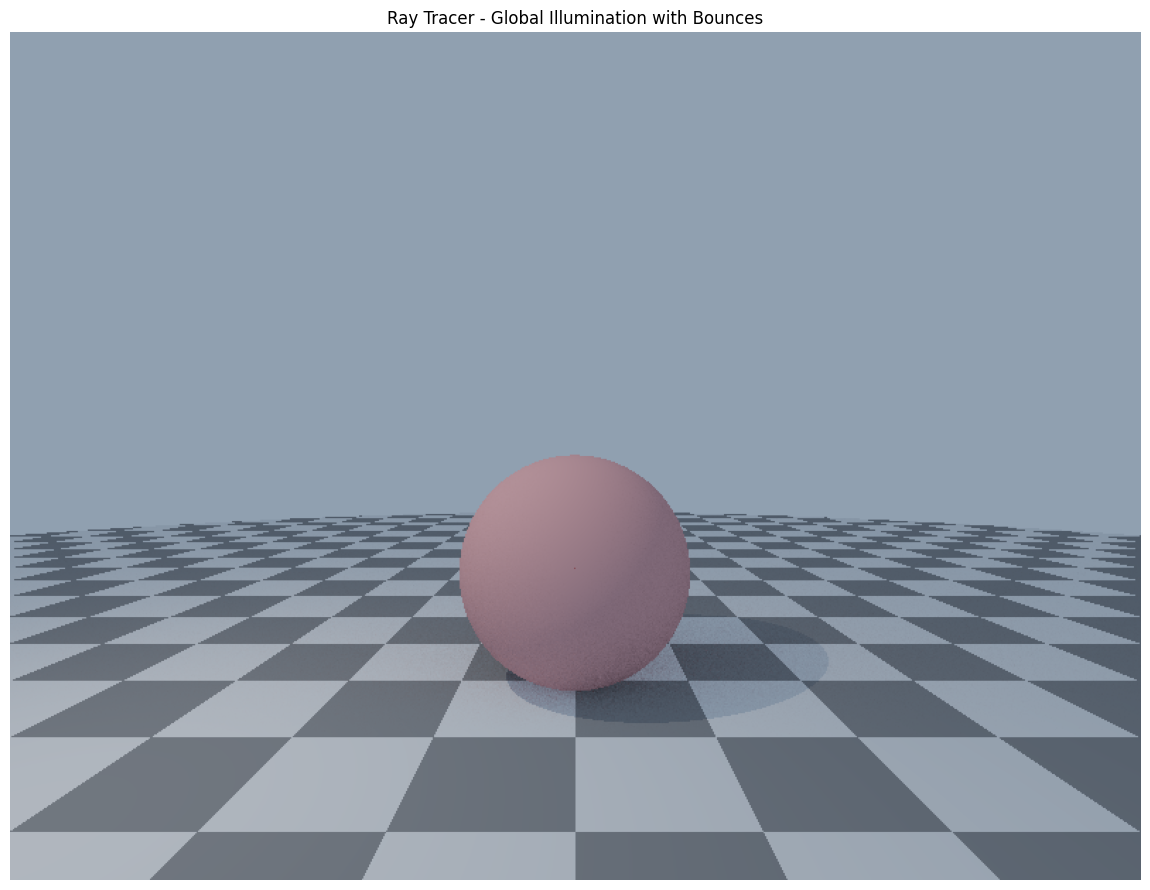

Rendering complete!


In [ ]:
print("Rendering with proper ray tracing...")
print(f"Resolution: {width}x{height}")
print(f"Max bounces: {max_bounces}")
print(f"Samples per pixel: {samples_per_pixel}")
print(f"Material roughness: {material_roughness}")

# Render
render()

# Convert and display
img_np = image.to_numpy()
img_np = np.flipud(img_np)
img_np = np.clip(img_np, 0, 1)

img_np = np.rot90(img_np, k=1)

plt.figure(figsize=(12, 9))
plt.imshow(img_np)
plt.title("Ray Tracer - Global Illumination with Bounces")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Rendering complete!")